<a href="https://colab.research.google.com/github/JAntonioRosales/CE888-Data-Science/blob/main/project/code/passenger_satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Passenger Satisfaction (Flight Survey Dataset)

## 1 - Description

This dataset contains responses from a flight satisfaction survey filled out by an airline's customers. The dataset is already divided into training and testing, separating 103,904 samples (80%) for training and 25,976 samples for testing (20%).

The attributes filled out by the passengers are the following:

1. Gender
2. Customer Type
3. Age
4. Type of Travel
5. Class
6. Flight Distance
7. Inflight WiFi Service
8. Departure/Arrival Time Convenience
9. Ease of Online Booking
10. Gate Location
11. Food and Drink
12. Online Boarding
13. Seat Comfort
14. Inflight Entertainment
15. On-board Service
16. Leg Room Service
17. Baggage Handling
18. Check-in Service
19. Inflight Service
20. Cleanliness
21. Departure Delay in Minutes
22. Arrival Delay in Minutes
23. Satisfaction

The dataset was provided by TJ Klein and can be found on Kaggle at: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction?select=train.csv

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# Function for surrogate creation
def create_surrogate(majority, minority, imb):
  
  # Subsampling
  no_min_samples = int(majority.shape[0] * ((1/imb) - 1))
  min_indices = np.random.choice(range(minority.shape[0]), size=no_min_samples, replace=False) # Make sure we don't get the same sample more than once
  min_samples = minority.iloc[min_indices]
  
  # Surrogate dataset
  return pd.concat([majority, min_samples])

## 2 - Data exploration and visualization

In [3]:
# Loading and visualizing the data
flight = pd.read_csv('https://raw.githubusercontent.com/JAntonioRosales/CE888-Data-Science/main/project/datasets/flight_satisfaction_train.csv')
flight

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,satisfied
103901,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


Similar to the Song Likeability dataset, we have an additional indexing column that we can drop. We can also see that there is an 'id' feature that refers to the survey's registration number; since it does not provide information of any type we will drop it as well.

In [4]:
# Dropping additional indexing column and 'id' feature
flight = flight.drop(columns=['Unnamed: 0', 'id'])
flight.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


We now print information to see our data types.

In [5]:
# Printing dataset info
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [6]:
# Counting missing values
flight.isnull().sum().sum()

310

We have 103,904 samples (responses), 22 features, one target, and some missing values for *Arrival Delay in Minutes*.

The first five features, *gender*, *customer type*, *age*, *type of travel*, and *class*, refer to information about the passenger. Age is a **numerical** variable while the other features are **categorical**, and we can assume *gender* is **binary**, but we will have to look into the other ones as they could be **non-ordinal**, **ordinal**, or even **binary** as well.

The rest of the features are **numerical**, but there are two main types:

1. *Flight distance*, *departure delay in minutes*, and *arrival delay in minutes* all have different ranges, each pertaining to their specific scenarios.
2. The remaining features have values that seem to range from 1 to 5, where 1 is completely dissatisfied and 5 is completely satisfied. In a sense they are like **ordinal categorical** values that were transcribed as integers in the survey.

Lastly, the label is binary, having values of 'neutral or dissatisfied' and 'satisfied'.

We will begin by encoding the label to 0 and 1, respectively; we will then, encode the categorical features; and once our features are numerical and easier to handle, we will deal with the missing values.

In [7]:
# Encoding the label to numeric values
le = LabelEncoder()
flight['satisfaction'] = le.fit_transform(flight['satisfaction'])
flight.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


Now, let us analyze the few **categorical** features to see how to deal with them.

In [8]:
# Different values for 'Gender'
flight['Gender'].value_counts()

Female    52727
Male      51177
Name: Gender, dtype: int64

*Gender* is, indeed, binary, so we can assign values of 0 for 'Male' and 1 for 'Female'.

In [9]:
# Different values for 'Customer Type'
flight['Customer Type'].value_counts()

Loyal Customer       84923
disloyal Customer    18981
Name: Customer Type, dtype: int64

*Customer Type* is also binary, so we will encode 'disloyal Customer' as 0 and 'Loyal Customer' as 1.

In [10]:
# Different values for 'Type of Travel'
flight['Type of Travel'].value_counts()

Business travel    71655
Personal Travel    32249
Name: Type of Travel, dtype: int64

It seems we are in a binary streak. We will also encode *Type of Travel* as 0 for 'Personal Travel' and 1 for 'Business travel'.

In [11]:
# Different values for 'Class'
flight['Class'].value_counts()

Business    49665
Eco         46745
Eco Plus     7494
Name: Class, dtype: int64

*Class* has three possible values that can be considered as ordinal. Economy, followed by Economy Plus, and finally, Business class.

We will encode them as 0, 1, and 2, respectively.

We will use an Ordinal Encoder to convert these **categorical** features into **numerical** ones. Even though the first three are binary and do not have an ordinal relationship, the encoder will set them as 0 and 1.

In [12]:
# Retrieving the column names that will be transformed with OrdinalEncoder and defining the order of their catrgories
ord_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
gender_categories = ['Male', 'Female']
customer_categories = ['disloyal Customer', 'Loyal Customer']
travel_categories = ['Personal Travel', 'Business travel']
class_categories = ['Eco', 'Eco Plus', 'Business']

# Retrieving the remaining column names and creating a list of column names with the order produced by the Column Transformer (later used to construct a dataframe)
rem_features = flight.columns.drop(ord_features).tolist() # .tolist() used because the output was a Pandas Index
cols = ord_features + rem_features

# Encoding the categorical features previously discussed
colTransformer = ColumnTransformer([('ord', OrdinalEncoder(categories=[gender_categories, customer_categories, travel_categories, class_categories]), ord_features)],
                                   remainder='passthrough')
flight_processed = colTransformer.fit_transform(flight)

# Creating new dataframe with the encoded features
flight = pd.DataFrame(data=flight_processed, columns=cols, dtype='float')
flight

,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0.0,1.0,0.0,1.0,13.0,460.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,0.0
1,0.0,0.0,1.0,2.0,25.0,235.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,0.0
2,1.0,1.0,1.0,2.0,26.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,1.0
3,1.0,1.0,1.0,2.0,25.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,0.0
4,0.0,1.0,1.0,2.0,61.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,1.0,0.0,1.0,0.0,23.0,192.0,2.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,2.0,3.0,2.0,3.0,0.0,0.0
103900,0.0,1.0,1.0,2.0,49.0,2347.0,4.0,4.0,4.0,4.0,2.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,0.0,0.0,1.0
103901,0.0,0.0,1.0,2.0,30.0,1995.0,1.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,3.0,2.0,4.0,5.0,5.0,4.0,7.0,14.0,0.0
103902,1.0,0.0,1.0,0.0,22.0,1000.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,4.0,5.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0


After processing, the features were encoded as follows:

*Gender*

    0 == Male
    1 == Female

*Customer Type*

    0 == disloyal Customer
    1 == Loyal Customer

*Type of Travel*

    0 == Personal Travel
    1 == Business travel

*Class*

    0 == Eco
    1 == Eco Plus
    2 == Business

Now, the **missing values**.

In [13]:
# Locating missing values
flight.isnull().sum()

Gender                                 0
Customer Type                          0
Type of Travel                         0
Class                                  0
Age                                    0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

All of the missing values are in the *Arrival Delay in Minutes* feature.

In [14]:
# Percentage of missing values for the feature
mvals = flight.isnull().sum().sum()
print('Missing values:', mvals*100/flight.shape[0], '%')

Missing values: 0.29835232522328303 %


However, we can observe that they represent less than 0.3% of the samples for that feature. This is such a low count of missing values that we can afford to drop these responses and work with 99.7% of our training set. 300 samples out of almost 104,000 will not make much of a difference when training.

In [15]:
# Dropping rows with missing values
print("Responses before dropping missing values:", flight.shape[0])
flight = flight.dropna(axis=0)
print("Responses after dropping missing values:", flight.shape[0])

Responses before dropping missing values: 103904
Responses after dropping missing values: 103594


In [16]:
# Confirm no missing values
flight.isnull().sum().sum()

0

We confirm that there are no more missing values.

In [17]:
# Final shape of the dataset
flight.shape

(103594, 23)

And now, the final dataset has 103,594 samples, 22 features, and 1 target.

Now that all features are numerical we can print their information as well as their histograms.

In [18]:
# Info for numerical features
flight.describe()

,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000
mean,0.507520,0.817248,0.689857,1.028380,39.380466,1189.325202,2.729753,3.060081,2.756984,2.977026,3.202126,3.250497,3.439765,3.358341,3.382609,3.351401,3.631687,3.304323,3.640761,3.286397,14.747939,15.178678,0.433394
std,0.499946,0.386465,0.462554,0.962868,15.113125,997.297235,1.327866,1.525233,1.398934,1.277723,1.329401,1.349433,1.318896,1.333030,1.288284,1.315409,1.181051,1.265396,1.175603,1.312194,38.116737,38.698682,0.495546
min,0.000000,0.000000,0.000000,0.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,40.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,2.000000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,1.000000,1.000000,1.000000,2.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


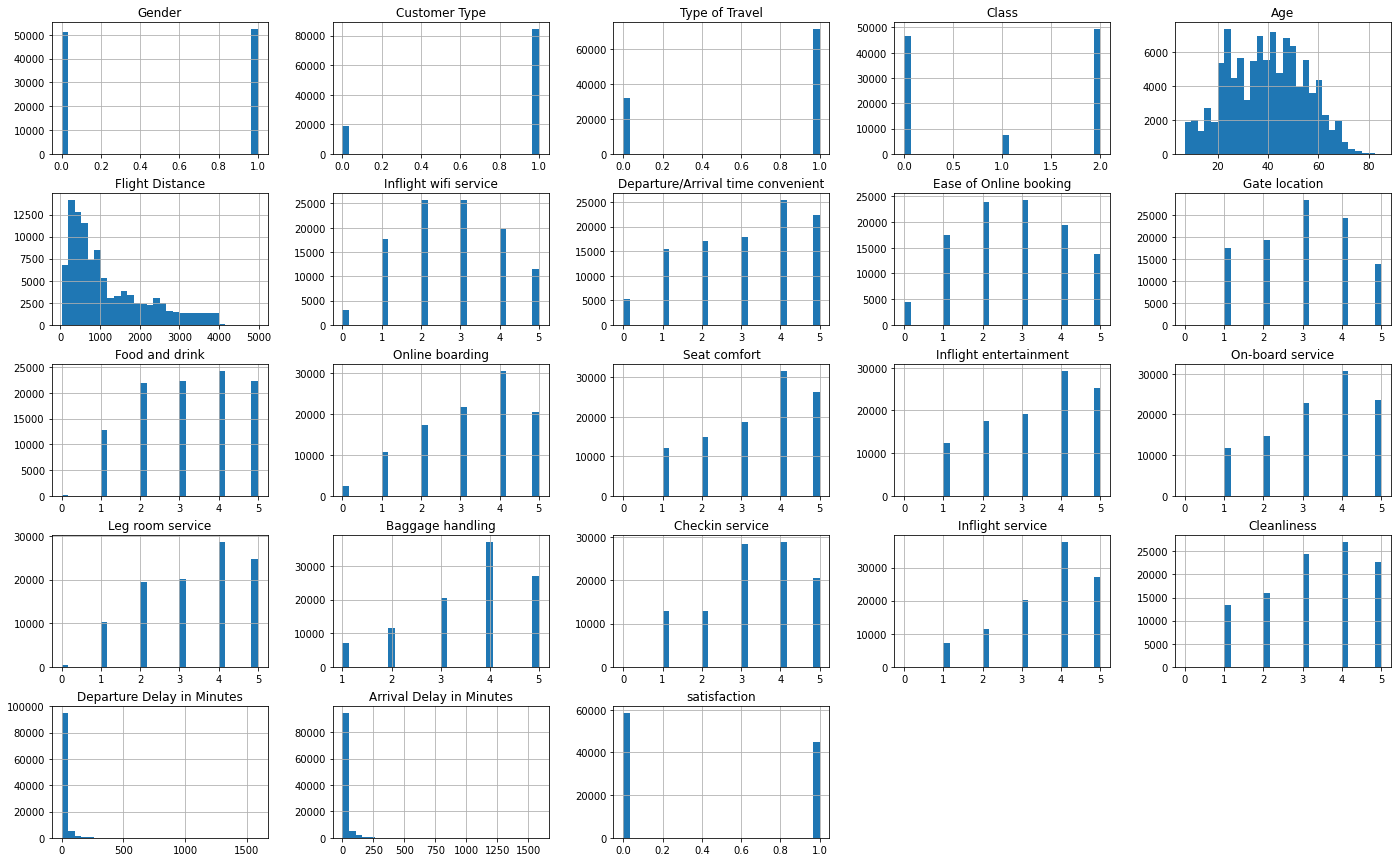

In [19]:
# Plotting numerical features
blob = flight.hist(bins=30, figsize=(24, 15))
plt.savefig('flight_complete_hist.pdf', dpi=1200, bbox_inches='tight')

The first thing we are able to notice is that, indeed, the minority of the features are continuous. Namely, *age* (which is distributed rather normally), *flight distance*, *departure delay in minutes*, and *arrival delay in minutes* (which are all skewed towards low values). Interestingly, the last two features have a very wide range, indicating possible outliers or extreme cases where the passengers had delays of around 1500 minutes.

We can also visualize the features we previously transformed (the first four), observing a balance between genders, a large number of 'Loyal Customers', a very low count of 'Economy Plus' travelers, and a ratio of approximately 2 'Business' travelers for every 'Personal' traveler.

The rest of the features, which we mentioned could be in a range of 1 to 5, are actually in a range of 0 to 5. The majority of them are lightly skewed towards the high scores, but *Inflight wifi service*, *Ease of Online booking*, and *Gate location* are more normally distributed.

On a final note, we turn our attention to our *satisfaction* label. We confirm it is binary, but we can also notice a slight imbalance on the set, so we can go ahead and analyze it more thoroughly.

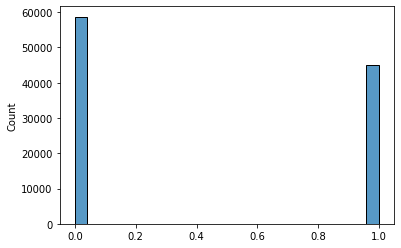

In [20]:
# Plotting 'satisfaction' histogram to analyze its balance
blob = sns.histplot(flight['satisfaction'].values)

In [21]:
# Calculating the imbalance of the dataset
value, count = np.unique(flight['satisfaction'].values, return_counts=True)
print('Dissatisfied:', (count[0]*100/(count[0]+count[1])), '%')
print('Satisfied:', (count[1]*100/(count[0]+count[1])), '%')

Dissatisfied: 56.660617410274725 %
Satisfied: 43.339382589725275 %


There is a slight imbalance in the set, having 56.6% of dissatisfied passengers and 43.3% of satisfied passengers. Ideally, we would have 50% and 50%, but this slight imbalance is tolerable for our studies, for the lowest level of imbalance we will deal with is 65%.

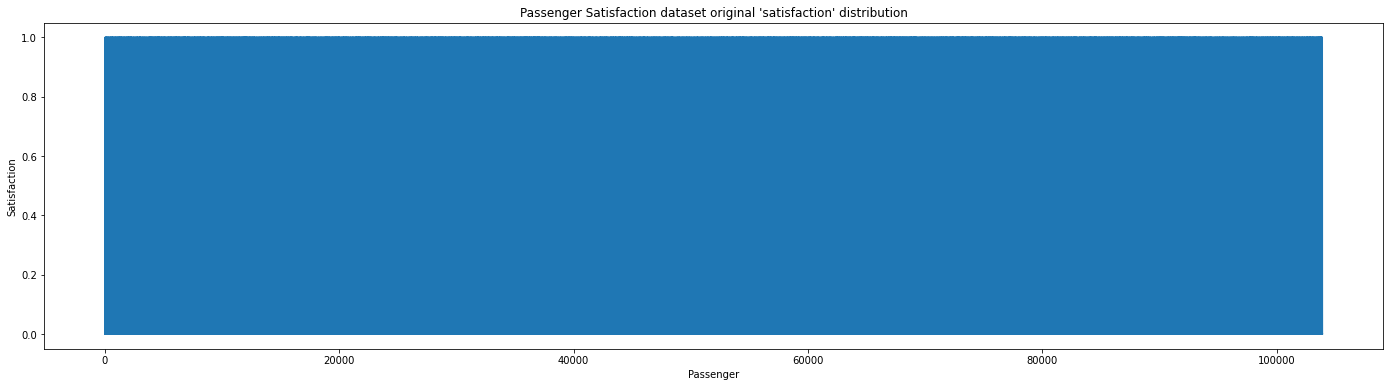

In [22]:
# Plotting the distribution of 0s and 1s
plt.figure(figsize=(24,6))
sns.lineplot(data=flight['satisfaction'])
plt.title("Passenger Satisfaction dataset original 'satisfaction' distribution")
plt.xlabel('Passenger')
plt.ylabel('Satisfaction')
plt.savefig('flight_target_dist.pdf', dpi=1200, bbox_inches='tight')

In terms of the distribution of the label, the values are mixed. The plot does not have enough resolution to show every single sample (because there are almost 104,000 of them), but the the results are varying between 0 and 1 and that is the reason we see a continuous bar. Otherwise we could see 'light' spots, or 'breaks' in the middle of the bar, indicating a group of only 'dissatisfied' or only 'satisfied' passengers.

## 3 - Surrogates and splitting

The last stage is creating surrogates of the original dataset and splitting into testing and training sets. However, this dataset was already divided into testing and training. So we will load the testing set and perform the same preprocessing we just did for the training set before creating the surrogates.

In [23]:
# Loading and visualizing the data
flight_test = pd.read_csv('https://raw.githubusercontent.com/JAntonioRosales/CE888-Data-Science/main/project/datasets/flight_satisfaction_test.csv')
flight_test

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,25971,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,25972,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
25973,25973,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,25974,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied


In [24]:
# Dropping additional indexing column and 'id' feature
flight_test = flight_test.drop(columns=['Unnamed: 0', 'id'])

# Encoding the label to numeric values discovered in training
flight_test['satisfaction'] = le.transform(flight_test['satisfaction'])

# Encoding the categorical features discovered in training
flight_test_processed = colTransformer.transform(flight_test)

# Creating new dataframe with the encoded features
flight_test = pd.DataFrame(data=flight_test_processed, columns=cols, dtype='float')
flight_test

,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1.0,1.0,1.0,0.0,52.0,160.0,5.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,50.0,44.0,1.0
1,1.0,1.0,1.0,2.0,36.0,2863.0,1.0,1.0,3.0,1.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,20.0,192.0,2.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0
3,0.0,1.0,1.0,2.0,44.0,3377.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,6.0,1.0
4,1.0,1.0,1.0,0.0,49.0,1182.0,2.0,3.0,4.0,3.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,4.0,0.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,0.0,0.0,1.0,2.0,34.0,526.0,3.0,3.0,3.0,1.0,4.0,3.0,4.0,4.0,3.0,2.0,4.0,4.0,5.0,4.0,0.0,0.0,0.0
25972,0.0,1.0,1.0,2.0,23.0,646.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,0.0,0.0,1.0
25973,1.0,1.0,0.0,0.0,17.0,828.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,4.0,3.0,4.0,5.0,4.0,2.0,0.0,0.0,0.0
25974,0.0,1.0,1.0,2.0,14.0,1127.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,4.0,5.0,4.0,0.0,0.0,1.0


As a sanity check, we will analyze the test set's balance and target distribution.

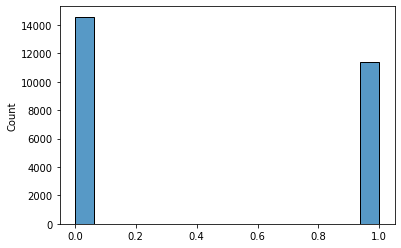

In [25]:
# Plotting 'satisfaction' histogram to analyze its balance
blob = sns.histplot(flight_test['satisfaction'].values)

In [26]:
# Calculating the imbalance of the dataset
value, count = np.unique(flight_test['satisfaction'].values, return_counts=True)
print('Dissatisfied:', (count[0]*100/(count[0]+count[1])), '%')
print('Satisfied:', (count[1]*100/(count[0]+count[1])), '%')

Dissatisfied: 56.10178626424392 %
Satisfied: 43.89821373575608 %


We can observe that the test set is as balanced as the training set, so we are on the right track.

Text(0, 0.5, 'Satisfaction')

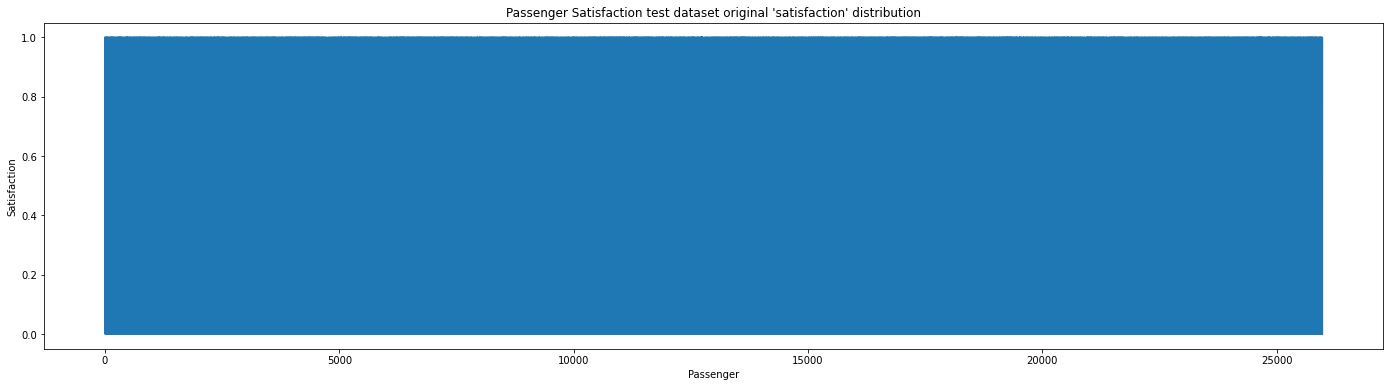

In [27]:
# Plotting the distribution of 0s and 1s
plt.figure(figsize=(24,6))
sns.lineplot(data=flight_test['satisfaction'])
plt.title("Passenger Satisfaction test dataset original 'satisfaction' distribution")
plt.xlabel('Passenger')
plt.ylabel('Satisfaction')

And, again, the target distribution indicates the 0s and 1s are blended.

Finally, we check if the test set also has missing values.

In [28]:
# Locating missing values
flight_test.isnull().sum()

Gender                                0
Customer Type                         0
Type of Travel                        0
Class                                 0
Age                                   0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

It does have missing values, again, for the *Arrival Delay in Minutes* feature.

In [29]:
# Percentage of missing values for the feature
mvals_test = flight_test.isnull().sum().sum()
print('Test set missing values:', mvals_test*100/flight_test.shape[0], '%')

Test set missing values: 0.31952571604558055 %


Similar to the training set, the missing values only represent around 0.3% of the total number of responses for that feature, so we can drop those responses.

In [30]:
# Dropping rows with missing values
print("Responses before dropping missing values:", flight_test.shape[0])
flight_test = flight_test.dropna(axis=0)
print("Responses after dropping missing values:", flight_test.shape[0])

Responses before dropping missing values: 25976
Responses after dropping missing values: 25893


And we confirm we have no more missing values.

In [31]:
# Confirm no missing values
flight_test.isnull().sum().sum()

0

The final shape of the test set is...

In [32]:
# Shape of the dataset
flight_test.shape

(25893, 23)

Now it is time to create the imbalanced surrogates from both, training and testing sets.

We will assume our passengers are more squeamish about the services provided by the airline and, thus are more likely to dislike their experience. We will keep the same number of dissatisfied customers as in the original datasets, and will decrease the satisfied ones to generate the desired imbalances.

In [33]:
# Dividing the datasets into satisfied and dissatisfied passengers - TRAIN
sat_train = flight.loc[flight['satisfaction']==1]
dis_train = flight.loc[flight['satisfaction']==0]

# Dividing the datasets into satisfied and dissatisfied passengers - TEST
sat_test = flight_test.loc[flight_test['satisfaction']==1]
dis_test = flight_test.loc[flight_test['satisfaction']==0]

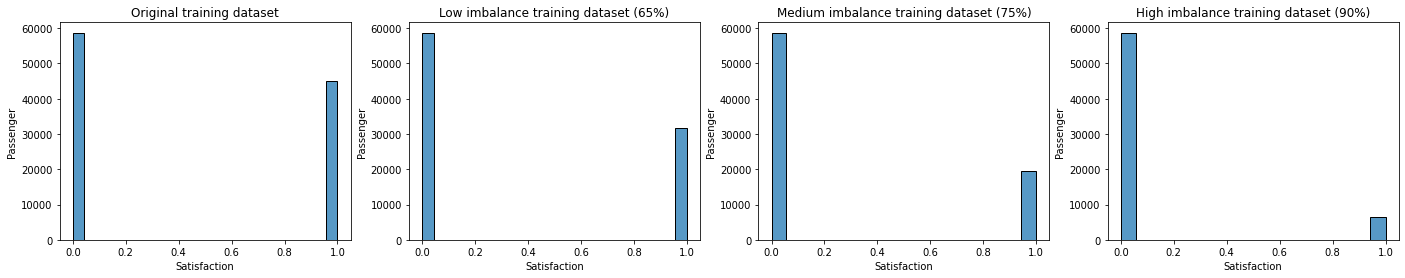

In [34]:
# Creating surrogate datasets - TRAIN
flight_li_train = create_surrogate(dis_train, sat_train, 0.65) # Low imbalance
flight_mi_train = create_surrogate(dis_train, sat_train, 0.75) # Medium imbalance
flight_hi_train = create_surrogate(dis_train, sat_train, 0.90) # High imbalance

# Plotting the different datasets
plt.figure(figsize=(24,4))

for plot in range(1,5):
  plt.subplot(1,4,plot)
  plt.xlabel('Satisfaction')
  plt.ylabel('Passenger')
  
  # Original set
  if plot == 1:
    sns.histplot(flight['satisfaction'].values)
    plt.title('Original training dataset')
  
  # Low imbalance dataset
  elif plot == 2:
    sns.histplot(flight_li_train['satisfaction'].values)
    plt.title('Low imbalance training dataset (65%)')
  
  # Medium imbalance dataset
  elif plot == 3:
    sns.histplot(flight_mi_train['satisfaction'].values)
    plt.title('Medium imbalance training dataset (75%)')
  
  # High imbalance dataset
  else:
    sns.histplot(flight_hi_train['satisfaction'].values)
    plt.title('High imbalance training dataset (90%)')

plt.savefig('flight_surrogates_train.pdf', dpi=1200, bbox_inches='tight')
plt.show()

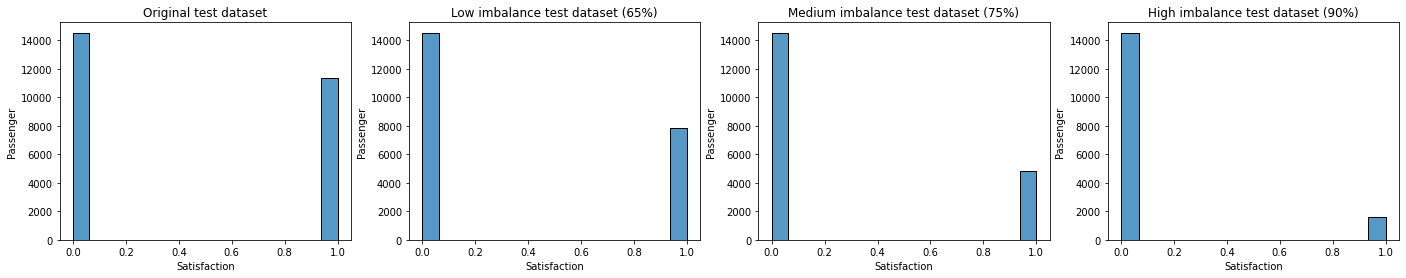

In [35]:
# Creating surrogate datasets - TEST
flight_li_test = create_surrogate(dis_test, sat_test, 0.65) # Low imbalance
flight_mi_test = create_surrogate(dis_test, sat_test, 0.75) # Medium imbalance
flight_hi_test = create_surrogate(dis_test, sat_test, 0.90) # High imbalance

# Plotting the different datasets
plt.figure(figsize=(24,4))

for plot in range(1,5):
  plt.subplot(1,4,plot)
  plt.xlabel('Satisfaction')
  plt.ylabel('Passenger')
  
  # Original set
  if plot == 1:
    sns.histplot(flight_test['satisfaction'].values)
    plt.title('Original test dataset')
  
  # Low imbalance dataset
  elif plot == 2:
    sns.histplot(flight_li_test['satisfaction'].values)
    plt.title('Low imbalance test dataset (65%)')
  
  # Medium imbalance dataset
  elif plot == 3:
    sns.histplot(flight_mi_test['satisfaction'].values)
    plt.title('Medium imbalance test dataset (75%)')
  
  # High imbalance dataset
  else:
    sns.histplot(flight_hi_test['satisfaction'].values)
    plt.title('High imbalance test dataset (90%)')

plt.savefig('flight_surrogates_test.pdf', dpi=1200, bbox_inches='tight')
plt.show()